Using CuPy (GPU acceleration)
Loading MNIST dataset...
Training data shape: (60000, 784), (60000, 10)
Test data shape: (10000, 784), (10000, 10)

parameters: dendrite_mask: 600.0
model params: 600


Training : 100%|█████████▉| 7020/7050 [00:06<00:00, 1031.66it/s, Epoch=30/30, Batch=234/235, Loss=0.3442]


number of mask updates: 60


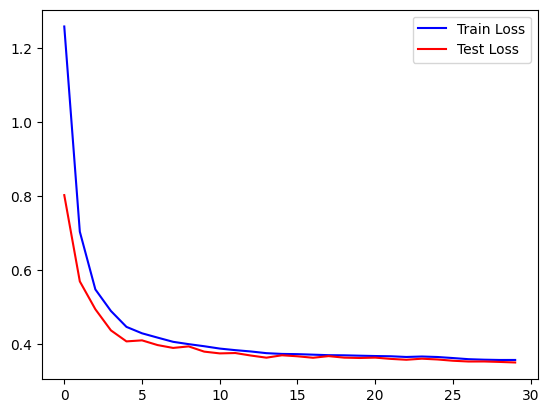

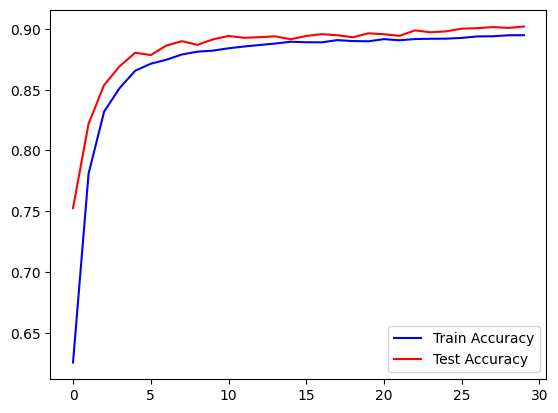

train loss: 0.358
test loss: 0.351
train accuracy: 0.895
test accuracy: 0.902
sum of mask: 600
number of mask updates: 60


In [ ]:
try:
    import cupy as cp
    # Test if CuPy can actually access CUDA and random number generator
    cp.cuda.Device(0).compute_capability
    cp.random.seed(1)  # Test if random number generator works
    print("Using CuPy (GPU acceleration)")
except (ImportError, Exception) as e:
    import numpy as cp

    print(f"CuPy not available or CUDA error ({type(e).__name__}), using NumPy (CPU)")

from utils import load_mnist_data
from matplotlib import pyplot as plt
from modules import CrossEntropy
from training import train


class Adam:
    def __init__(
        self,
        params,
        criterion,
        lr=0.01,
        beta1=0.9,
        beta2=0.999,
        eps=1e-8,
        weight_decay=0.0,
        grad_clip=None,
    ):
        self.params = params
        self.criterion = criterion
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0  # Global time step, increments once per batch
        self.weight_decay = weight_decay
        self.grad_clip = grad_clip

        # Initialize moment estimates - only for dendrite_W
        self.m = cp.zeros_like(self.params.dendrite_W)
        self.v = cp.zeros_like(self.params.dendrite_W)

    def zero_grad(self):
        self.params.dendrite_dW = 0.0
        # Ensure weights stay masked after each batch
        self.params.dendrite_W = self.params.dendrite_W * self.params.dendrite_mask

    def step(self):
        self.t += 1  # Increment global time step
        
        grad = self.params.dendrite_dW
        
        # Update first moment estimate
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        # Update second moment estimate
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad**2)

        # Bias correction
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)

        if self.grad_clip:
            m_hat = cp.clip(m_hat, -self.grad_clip, self.grad_clip)

        # Update parameters
        self.params.dendrite_W -= self.lr * m_hat / (cp.sqrt(v_hat) + self.eps)
        self.params.dendrite_W -= self.lr * self.weight_decay * self.params.dendrite_W
        
        # CRITICAL: Ensure weights stay masked - multiply by mask to zero out inactive connections
        self.params.dendrite_W = self.params.dendrite_W * self.params.dendrite_mask

    def __call__(self):
        return self.step()


class MinimalDendriticLayer:
    """A sparse dendritic layer, consiting of dendrites and somas"""

    def __init__(
        self,
        in_dim,
        n_dendrites,
        n_dendrite_inputs=16,
        synaptic_resampling=True,
        percentage_resample=0.005,
        scaling_resampling_percentage=False,
        steps_to_resample=100,
        stop_after_n_mask_updates=100,
        dynamic_steps_size=False,
    ):
        self.n_dendrites = n_dendrites
        # dynamicly resample
        self.synaptic_resampling = synaptic_resampling
        self.percentage_resample = percentage_resample
        self.steps_to_resample = steps_to_resample
        self.scaling_resampling_percentage = scaling_resampling_percentage
        self.dynamic_steps_size = dynamic_steps_size
        self.stop_after_n_mask_updates = stop_after_n_mask_updates
        # to keep track of resampling
        self.num_mask_updates = 1
        self.update_steps = 0

        self.in_dim = in_dim
        self.n_dendrite_inputs = n_dendrite_inputs
        self.dendrite_W = cp.random.randn(n_dendrites, in_dim) * cp.sqrt(
            2.0 / (in_dim)
        )  # He init, for ReLU
        self.dendrite_dW = 0.0

        # sample dendrite mask
        # for each dendrite sample n_dendrite_inputs from the input array
        self.dendrite_mask = cp.zeros((n_dendrites, in_dim))
        for i in range(n_dendrites):
            # sample without replacement from possible input for a given dendrite from the whole input
            input_idx = cp.random.choice(
                cp.arange(in_dim), size=n_dendrite_inputs, replace=False
            )
            self.dendrite_mask[i, input_idx] = 1

        # mask out unneeded weights, thus making weights sparse
        self.dendrite_W = self.dendrite_W * self.dendrite_mask

    def forward(self, x):
        # dendrites forward pass
        self.dendrite_x = x
        x = x @ self.dendrite_W.T
        return x

    def backward(self, grad):
        # dendrite back pass
        self.dendrite_dW = grad.T @ self.dendrite_x * self.dendrite_mask
        dendrite_grad = grad @ self.dendrite_W
        
        # Ensure weights stay masked - critical for maintaining connection count
        self.dendrite_W = self.dendrite_W * self.dendrite_mask

        if self.synaptic_resampling:
            self.update_steps += 1

            
            # if enough steps have passed, resample
            if self.dynamic_steps_size:
                resample_bool = self.update_steps >= 100 + 5 * self.num_mask_updates
                # resample_bool = self.update_steps >= cp.exp((self.num_mask_updates + 20) / 10 ) + 20
            else:
                # resample_bool = self.update_steps >= 20 + 10 * self.num_mask_updates
                resample_bool = self.update_steps >= self.steps_to_resample and self.num_mask_updates < self.stop_after_n_mask_updates
                # if self.update_steps == 500:
                    # print("LAST UPDATE")
            if resample_bool:
                # reset step counter
                self.update_steps = 0
                self.resample_dendrites()
                
                
        return dendrite_grad

    def resample_dendrites(self):
        # --- Part 1: Connection Removal ---
        if self.scaling_resampling_percentage:
            resampling_percentage = 1 / (1 + 0.1 * self.num_mask_updates)
        else:
            resampling_percentage = self.percentage_resample

        n_to_remove_per_dendrite = int(self.n_dendrite_inputs * resampling_percentage)
        if n_to_remove_per_dendrite == 0:
            print("No dendrites to remove")
            return

        num_dendrites = self.dendrite_mask.shape[0]

        # For magnitude, we remove the smallest. Set inactive connections to infinity so they are not picked.
        metric = cp.abs(self.dendrite_W)
        metric[self.dendrite_mask == 0] = cp.inf
        sorted_indices = cp.argsort(metric, axis=1)
        cols_to_remove = sorted_indices[:, :n_to_remove_per_dendrite]

        # Create corresponding row indices and flatten for the swap logic
        rows_to_remove = cp.arange(num_dendrites)[:, cp.newaxis]
        removed_dendrite_indices = rows_to_remove.repeat(n_to_remove_per_dendrite, axis=1).flatten()
        removed_input_indices = cols_to_remove.flatten()

        n_connections_to_remove = removed_dendrite_indices.size
        
        # --- Part 2: One-shot Resampling Attempt ---
        num_inputs_per_dendrite = self.dendrite_x.shape[1]

        newly_selected_input_indices = cp.random.randint(
            0, num_inputs_per_dendrite, size=n_connections_to_remove, dtype=int
        )

        # --- Part 3: Conflict Detection ---
        conflict_with_existing = self.dendrite_mask[removed_dendrite_indices, newly_selected_input_indices] == 1
        
        num_dendrites = self.dendrite_mask.shape[0]
        proposed_flat_indices = removed_dendrite_indices * num_inputs_per_dendrite + newly_selected_input_indices
        counts = cp.bincount(proposed_flat_indices.astype(int), minlength=num_dendrites * num_inputs_per_dendrite)
        is_duplicate_flat = counts[proposed_flat_indices.astype(int)] > 1
        
        is_problematic = conflict_with_existing | is_duplicate_flat
        is_successful = ~is_problematic

        # --- Part 4: Apply Successful Swaps ---
        dendrites_to_swap = removed_dendrite_indices[is_successful]
        old_inputs_to_remove = removed_input_indices[is_successful]
        new_inputs_to_add = newly_selected_input_indices[is_successful]

        if dendrites_to_swap.size > 0:
            self.dendrite_mask[dendrites_to_swap, old_inputs_to_remove] = 0
            self.dendrite_mask[dendrites_to_swap, new_inputs_to_add] = 1

            self.dendrite_W[dendrites_to_swap, new_inputs_to_add] = (
                cp.random.randn(dendrites_to_swap.shape[0]) * cp.sqrt(2.0 / self.in_dim)
            )
            
            
        self.dendrite_W = self.dendrite_W * self.dendrite_mask
        
        # print(f"num of dendrite successful swaps: {dendrites_to_swap.size}")
        self.num_mask_updates += 1
        
        # --- Part 5: Verification ---
        connections_per_dendrite = cp.sum(self.dendrite_mask, axis=1)
        connections_per_dendrite_weights = cp.count_nonzero(self.dendrite_W, axis=1)
        assert cp.all(connections_per_dendrite == self.n_dendrite_inputs), \
            f"Resampling failed: not all dendrites have {self.n_dendrite_inputs} connections."
        assert cp.all(connections_per_dendrite_weights == self.n_dendrite_inputs), \
            f"Resampling failed: not all dendrites have {self.n_dendrite_inputs} connections."

    def num_params(self):
        print(
            f"\nparameters: dendrite_mask: {cp.sum(self.dendrite_mask)}"
        )
        return int(cp.sum(self.dendrite_mask))

    def __call__(self, x):
        return self.forward(x)


# def main():
cp.random.seed(1902)

# data config
dataset = "mnist"  # "mnist", "fashion-mnist", "cifar10"

# config
n_epochs = 30 # 15 MNIST, 20 Fashion-MNIST
lr = 0.002  # 0.003
weight_decay = 0.01 #0.001
batch_size = 256
grad_clip = 100.0

in_dim = 28 * 28  # Image dimensions (28x28 MNIST, 32x32x3 CIFAR-10)

# dendriticmodel config
n_dendrite_inputs = 60
n_dendrites = 10  # 10 classes for MNIST
X_train, y_train, X_test, y_test = load_mnist_data(dataset=dataset)

criterion = CrossEntropy()
model = MinimalDendriticLayer(
    in_dim,
    n_dendrites,
    n_dendrite_inputs=n_dendrite_inputs,
    synaptic_resampling=True,
    percentage_resample=0.25,
    steps_to_resample=100,
    stop_after_n_mask_updates=60,
)
optimiser = Adam(model, criterion, lr=lr, weight_decay=weight_decay, grad_clip=grad_clip)

print(f"model params: {model.num_params()}")

train_losses, train_accuracy, test_losses, test_accuracy, _ = train(
    X_train,
    y_train,
    X_test,
    y_test,
    model,
    criterion,
    optimiser,
    n_epochs=n_epochs,
    batch_size=batch_size,
    track_variance=False,
)

print(f"number of mask updates: {model.num_mask_updates}")

# plot train and test accuracy
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(test_losses, label="Test Loss", color="red")
plt.legend()
plt.show()  

plt.plot(train_accuracy, label="Train Accuracy", color="blue")
plt.plot(test_accuracy, label="Test Accuracy", color="red")
plt.legend()
plt.show()

print(f"train loss: {train_losses[-1]:.3f}")
print(f"test loss: {test_losses[-1]:.3f}")
print(f"train accuracy: {train_accuracy[-1]:.3f}")
print(f"test accuracy: {test_accuracy[-1]:.3f}")

# plot_dendritic_weights_full_model(model, X_test[0])
# for i in range(10):
    # plot_dendritic_weights_single_image(model, X_test[0], neuron_idx=i)

lll = cp.count_nonzero(model.dendrite_W)
print(f"sum of mask: {lll}")
print(f"number of mask updates: {model.num_mask_updates}")
# if __name__ == "__main__":
#     main()

Using CuPy (GPU acceleration)
Loading MNIST dataset...
Training data shape: (60000, 784), (60000, 10)
Test data shape: (10000, 784), (10000, 10)

parameters: dendrite_mask: 180.0
model params: 180


Training : 100%|█████████▉| 7020/7050 [00:06<00:00, 1031.15it/s, Epoch=30/30, Batch=234/235, Loss=0.7280]


number of mask updates: 60


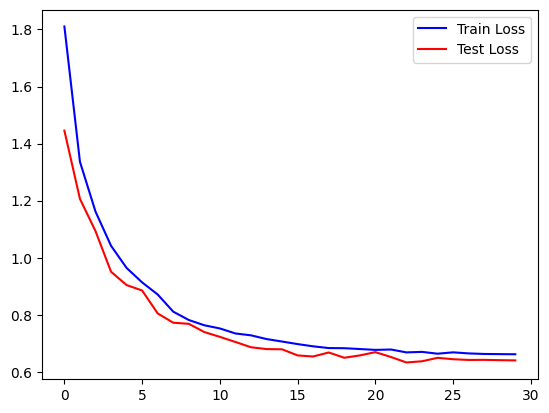

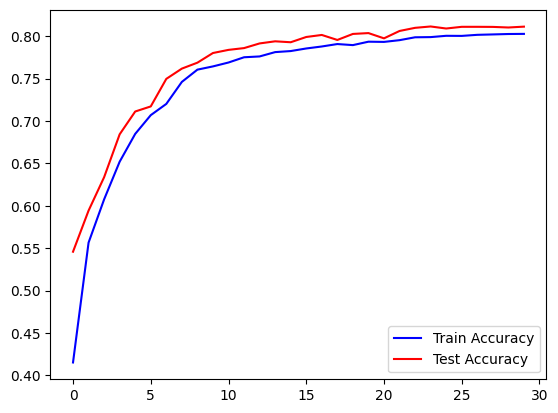

train loss: 0.662
test loss: 0.640
train accuracy: 0.803
test accuracy: 0.811
sum of mask: 180
number of mask updates: 60


In [ ]:
try:
    import cupy as cp
    # Test if CuPy can actually access CUDA and random number generator
    cp.cuda.Device(0).compute_capability
    cp.random.seed(1)  # Test if random number generator works
    print("Using CuPy (GPU acceleration)")
except (ImportError, Exception) as e:
    import numpy as cp

    print(f"CuPy not available or CUDA error ({type(e).__name__}), using NumPy (CPU)")

from utils import load_mnist_data
from matplotlib import pyplot as plt
from modules import CrossEntropy
from training import train


class Adam:
    def __init__(
        self,
        params,
        criterion,
        lr=0.01,
        beta1=0.9,
        beta2=0.999,
        eps=1e-8,
        weight_decay=0.0,
        grad_clip=None,
    ):
        self.params = params
        self.criterion = criterion
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0  # Global time step, increments once per batch
        self.weight_decay = weight_decay
        self.grad_clip = grad_clip

        # Initialize moment estimates - only for dendrite_W
        self.m = cp.zeros_like(self.params.dendrite_W)
        self.v = cp.zeros_like(self.params.dendrite_W)

    def zero_grad(self):
        self.params.dendrite_dW = 0.0
        # Ensure weights stay masked after each batch
        self.params.dendrite_W = self.params.dendrite_W * self.params.dendrite_mask

    def step(self):
        self.t += 1  # Increment global time step
        
        grad = self.params.dendrite_dW
        
        # Update first moment estimate
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        # Update second moment estimate
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad**2)

        # Bias correction
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)

        if self.grad_clip:
            m_hat = cp.clip(m_hat, -self.grad_clip, self.grad_clip)

        # Update parameters
        self.params.dendrite_W -= self.lr * m_hat / (cp.sqrt(v_hat) + self.eps)
        self.params.dendrite_W -= self.lr * self.weight_decay * self.params.dendrite_W
        
        # CRITICAL: Ensure weights stay masked - multiply by mask to zero out inactive connections
        self.params.dendrite_W = self.params.dendrite_W * self.params.dendrite_mask

    def __call__(self):
        return self.step()


class MinimalDendriticLayer:
    """A sparse dendritic layer, consiting of dendrites and somas"""

    def __init__(
        self,
        in_dim,
        n_dendrites,
        n_dendrite_inputs=16,
        synaptic_resampling=True,
        percentage_resample=0.005,
        scaling_resampling_percentage=False,
        steps_to_resample=100,
        stop_after_n_mask_updates=100,
        dynamic_steps_size=False,
    ):
        self.n_dendrites = n_dendrites
        # dynamicly resample
        self.synaptic_resampling = synaptic_resampling
        self.percentage_resample = percentage_resample
        self.steps_to_resample = steps_to_resample
        self.scaling_resampling_percentage = scaling_resampling_percentage
        self.dynamic_steps_size = dynamic_steps_size
        self.stop_after_n_mask_updates = stop_after_n_mask_updates
        # to keep track of resampling
        self.num_mask_updates = 1
        self.update_steps = 0

        self.in_dim = in_dim
        self.n_dendrite_inputs = n_dendrite_inputs
        self.dendrite_W = cp.random.randn(n_dendrites, in_dim) * cp.sqrt(
            2.0 / (in_dim)
        )  # He init, for ReLU
        self.dendrite_dW = 0.0

        # sample dendrite mask
        # for each dendrite sample n_dendrite_inputs from the input array
        self.dendrite_mask = cp.zeros((n_dendrites, in_dim))
        for i in range(n_dendrites):
            # sample without replacement from possible input for a given dendrite from the whole input
            input_idx = cp.random.choice(
                cp.arange(in_dim), size=n_dendrite_inputs, replace=False
            )
            self.dendrite_mask[i, input_idx] = 1

        # mask out unneeded weights, thus making weights sparse
        self.dendrite_W = self.dendrite_W * self.dendrite_mask

    def forward(self, x):
        # dendrites forward pass
        self.dendrite_x = x
        x = x @ self.dendrite_W.T
        return x

    def backward(self, grad):
        # dendrite back pass
        self.dendrite_dW = grad.T @ self.dendrite_x * self.dendrite_mask
        dendrite_grad = grad @ self.dendrite_W
        
        # Ensure weights stay masked - critical for maintaining connection count
        self.dendrite_W = self.dendrite_W * self.dendrite_mask

        if self.synaptic_resampling:
            self.update_steps += 1

            
            # if enough steps have passed, resample
            if self.dynamic_steps_size:
                resample_bool = self.update_steps >= 100 + 5 * self.num_mask_updates
                # resample_bool = self.update_steps >= cp.exp((self.num_mask_updates + 20) / 10 ) + 20
            else:
                # resample_bool = self.update_steps >= 20 + 10 * self.num_mask_updates
                resample_bool = self.update_steps >= self.steps_to_resample and self.num_mask_updates < self.stop_after_n_mask_updates
                # if self.update_steps == 500:
                    # print("LAST UPDATE")
            if resample_bool:
                # reset step counter
                self.update_steps = 0
                self.resample_dendrites()
                
                
        return dendrite_grad

    def resample_dendrites(self):
        # --- Part 1: Connection Removal ---
        if self.scaling_resampling_percentage:
            resampling_percentage = 1 / (1 + 0.1 * self.num_mask_updates)
        else:
            resampling_percentage = self.percentage_resample

        n_to_remove_per_dendrite = int(self.n_dendrite_inputs * resampling_percentage)
        if n_to_remove_per_dendrite == 0:
            print("No dendrites to remove")
            return

        num_dendrites = self.dendrite_mask.shape[0]

        # For magnitude, we remove the smallest. Set inactive connections to infinity so they are not picked.
        metric = cp.abs(self.dendrite_W)
        metric[self.dendrite_mask == 0] = cp.inf
        sorted_indices = cp.argsort(metric, axis=1)
        cols_to_remove = sorted_indices[:, :n_to_remove_per_dendrite]

        # Create corresponding row indices and flatten for the swap logic
        rows_to_remove = cp.arange(num_dendrites)[:, cp.newaxis]
        removed_dendrite_indices = rows_to_remove.repeat(n_to_remove_per_dendrite, axis=1).flatten()
        removed_input_indices = cols_to_remove.flatten()

        n_connections_to_remove = removed_dendrite_indices.size
        
        # --- Part 2: One-shot Resampling Attempt ---
        num_inputs_per_dendrite = self.dendrite_x.shape[1]

        newly_selected_input_indices = cp.random.randint(
            0, num_inputs_per_dendrite, size=n_connections_to_remove, dtype=int
        )

        # --- Part 3: Conflict Detection ---
        conflict_with_existing = self.dendrite_mask[removed_dendrite_indices, newly_selected_input_indices] == 1
        
        num_dendrites = self.dendrite_mask.shape[0]
        proposed_flat_indices = removed_dendrite_indices * num_inputs_per_dendrite + newly_selected_input_indices
        counts = cp.bincount(proposed_flat_indices.astype(int), minlength=num_dendrites * num_inputs_per_dendrite)
        is_duplicate_flat = counts[proposed_flat_indices.astype(int)] > 1
        
        is_problematic = conflict_with_existing | is_duplicate_flat
        is_successful = ~is_problematic

        # --- Part 4: Apply Successful Swaps ---
        dendrites_to_swap = removed_dendrite_indices[is_successful]
        old_inputs_to_remove = removed_input_indices[is_successful]
        new_inputs_to_add = newly_selected_input_indices[is_successful]

        if dendrites_to_swap.size > 0:
            self.dendrite_mask[dendrites_to_swap, old_inputs_to_remove] = 0
            self.dendrite_mask[dendrites_to_swap, new_inputs_to_add] = 1

            self.dendrite_W[dendrites_to_swap, new_inputs_to_add] = (
                cp.random.randn(dendrites_to_swap.shape[0]) * cp.sqrt(2.0 / self.in_dim)
            )
            
            
        self.dendrite_W = self.dendrite_W * self.dendrite_mask
        
        # print(f"num of dendrite successful swaps: {dendrites_to_swap.size}")
        self.num_mask_updates += 1
        
        # --- Part 5: Verification ---
        connections_per_dendrite = cp.sum(self.dendrite_mask, axis=1)
        connections_per_dendrite_weights = cp.count_nonzero(self.dendrite_W, axis=1)
        assert cp.all(connections_per_dendrite == self.n_dendrite_inputs), \
            f"Resampling failed: not all dendrites have {self.n_dendrite_inputs} connections."
        assert cp.all(connections_per_dendrite_weights == self.n_dendrite_inputs), \
            f"Resampling failed: not all dendrites have {self.n_dendrite_inputs} connections."

    def num_params(self):
        print(
            f"\nparameters: dendrite_mask: {cp.sum(self.dendrite_mask)}"
        )
        return int(cp.sum(self.dendrite_mask))

    def __call__(self, x):
        return self.forward(x)


# def main():
cp.random.seed(1902)

# data config
dataset = "mnist"  # "mnist", "fashion-mnist", "cifar10"

# config
n_epochs = 30 # 15 MNIST, 20 Fashion-MNIST
lr = 0.002  # 0.003
weight_decay = 0.01 #0.001
batch_size = 256
grad_clip = 100.0

in_dim = 28 * 28  # Image dimensions (28x28 MNIST, 32x32x3 CIFAR-10)

# dendriticmodel config
n_dendrite_inputs = 18
n_dendrites = 10  # 10 classes for MNIST
X_train, y_train, X_test, y_test = load_mnist_data(dataset=dataset)

criterion = CrossEntropy()
model = MinimalDendriticLayer(
    in_dim,
    n_dendrites,
    n_dendrite_inputs=n_dendrite_inputs,
    synaptic_resampling=True,
    percentage_resample=0.25,
    steps_to_resample=100,
    stop_after_n_mask_updates=60,
)
optimiser = Adam(model, criterion, lr=lr, weight_decay=weight_decay, grad_clip=grad_clip)

print(f"model params: {model.num_params()}")

train_losses, train_accuracy, test_losses, test_accuracy, _ = train(
    X_train,
    y_train,
    X_test,
    y_test,
    model,
    criterion,
    optimiser,
    n_epochs=n_epochs,
    batch_size=batch_size,
    track_variance=False,
)

print(f"number of mask updates: {model.num_mask_updates}")

# plot train and test accuracy
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(test_losses, label="Test Loss", color="red")
plt.legend()
plt.show()  

plt.plot(train_accuracy, label="Train Accuracy", color="blue")
plt.plot(test_accuracy, label="Test Accuracy", color="red")
plt.legend()
plt.show()

print(f"train loss: {train_losses[-1]:.3f}")
print(f"test loss: {test_losses[-1]:.3f}")
print(f"train accuracy: {train_accuracy[-1]:.3f}")
print(f"test accuracy: {test_accuracy[-1]:.3f}")

# plot_dendritic_weights_full_model(model, X_test[0])
# for i in range(10):
    # plot_dendritic_weights_single_image(model, X_test[0], neuron_idx=i)

lll = cp.count_nonzero(model.dendrite_W)
print(f"sum of mask: {lll}")
print(f"number of mask updates: {model.num_mask_updates}")
# if __name__ == "__main__":
#     main()